Classification Predictions Data Loaded from /Users/gregruyoga/gmoneycodes/topquartile/topquartile/preds/regime_predsv2.csv. Shape: (21420, 3)
Initializing DataLoader...
Transforming covariates via DataLoader...
Reading data from: /Users/gregruyoga/gmoneycodes/topquartile/topquartile/data/covariates_may2025v2.csv
Found 134 raw ticker names.
 Applying TechnicalCovariateTransform with params {'sma': [10]}
THIS IS COLUMNS Index(['TOTAL_EQUITY', 'BOOK_VAL_PER_SH', 'REVENUE_PER_SH', 'RETURN_COM_EQY',
       'CUR_MKT_CAP', 'PX_LAST', 'TOT_DEBT_TO_TOT_ASSET',
       'TOT_DEBT_TO_TOT_EQY', 'BS_TOT_LIAB2', 'BS_TOT_ASSET', 'IS_EPS',
       'PX_HIGH', 'PX_LOW', 'PX_CLOSE_1D', 'PX_VOLUME', 'TURNOVER', 'ticker',
       'DVD_SH_12M'],
      dtype='object')

START group_transform for ADHI
Applying _add_sma
Applying _add_ema
Applying _add_rsi
Applying _add_macd
Applying _add_obv
Applying _add_roc
Applying _add_cmo
Applying _add_trix
Applying _add_atr
Applying _add_mfi
Applying _add_force_index
Applying

/Users/gregruyoga/gmoneycodes/topquartile/topquartile/modules/datamodule/transforms/label.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.ihsg.index = pd.to_datetime(self.ihsg.index)
/Users/gregruyoga/gmoneycodes/topquartile/topquartile/modules/datamodule/dataloader.py:176: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  self.data = self.data.apply(pd.to_numeric, errors='ignore')


Historical Market Data Loaded and Processed via DataLoader. Shape: (223635, 4)
Index Data Loaded from /Users/gregruyoga/gmoneycodes/topquartile/topquartile/data/ihsg_may2025.csv for benchmark. Shape: (2434, 1)
Trading signals prepared using classification predictions. 15842 signals with entry price.

--- Running Classification Strategy: Buy Class 4 ---
Backtesting 'Classification: Buy Class 4' from 2023-04-12 to 2024-05-09...
Note: P&L for ESSA (entry 2023-09-29) is 0. Could not determine/calculate valid excess return.
Note: P&L for ESSA (entry 2023-10-01) is 0. Could not determine/calculate valid excess return.
Note: P&L for ESSA (entry 2023-10-03) is 0. Could not determine/calculate valid excess return.

--- Plotting Classification Strategy Results ---

Classification Strategy (Buy Class 4) Results (Tail):
               MTM_Value  Cumulative_Realized_P&L          Cash  \
Date                                                              
2024-05-04  1.195737e+09             1.957366e

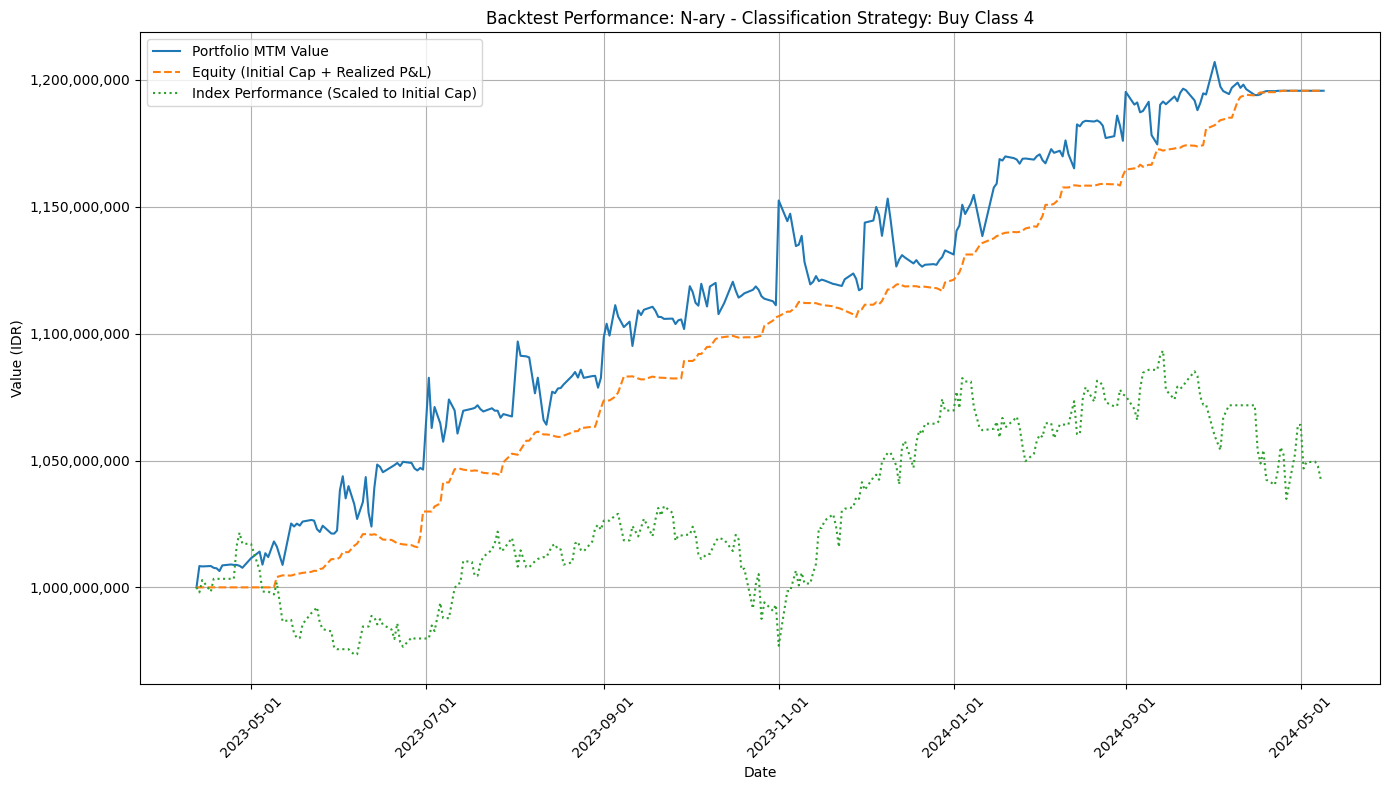

Final Memory used: 247.80 MB


In [6]:
import os
import gc
import psutil
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import BDay # For business day calculations

# --- Assuming these imports from your environment work perfectly ---
from topquartile.modules.datamodule.dataloader import DataLoader
from topquartile.modules.datamodule.transforms.covariate import TechnicalCovariateTransform
from topquartile.modules.datamodule.transforms.label import ExcessReturnTransform
from topquartile.modules.datamodule.partitions import PurgedTimeSeriesPartition

# Define paths (adjust if your structure is different)
# Assuming the script is in a 'scripts' or similar folder, and 'data' and 'preds' are siblings of 'topquartile'
# If script is at project root (same level as 'topquartile' folder), then root = Path().resolve()
try:
    script_dir = Path(__file__).resolve().parent
    root = script_dir.parent.parent # Adjust based on actual script location relative to project root
except NameError: # Fallback for interactive environments like Jupyter
    root = Path().resolve().parent.parent # Common structure, adjust if needed

index_path = root / 'data' / 'ihsg_may2025.csv'
# NEW: Path for classification predictions
classification_predictions_path = root / 'preds' / 'regime_predsv2.csv' # Example name

# --- Configuration ---
LABEL_DURATION = 20
INITIAL_CAPITAL = 1_000_000_000
TRADE_AMOUNT_PER_STOCK = 1_000_000
# STD_DEV_Z_SCORE is not needed for classification
MAX_FORWARD_LOOK_DAYS_FOR_EXIT = 5

# --- DataLoader Configuration (remains the same) ---
covtrans_config = [(
    TechnicalCovariateTransform,
    dict(sma=[10]),
)]
labeltrans_config = [(
    ExcessReturnTransform,
    dict(
        label_duration=LABEL_DURATION,
        index_csv="ihsg_may2025"
    )
)]
partition_config = dict(
    n_splits=5,
    gap=2,
    max_train_size=504,
    test_size=60,
)

# --- 1. Load and Prepare Data ---

# Load CLASSIFICATION Predictions
if not classification_predictions_path.exists():
    # Create a dummy classification_preds.csv for the script to run if not found
    print(f"Warning: Classification predictions file '{classification_predictions_path}' not found. Creating a dummy file.")
    dummy_class_preds_csv_data = """TickerIndex,DateIndex,pred_class
ADHI,2023-04-13,0
ANTM,2023-04-13,0
ARTO,2023-04-13,0
BBYB,2023-04-13,0
BNGA,2023-04-13,2
BRMS,2023-04-13,0
BSDE,2023-04-13,0
ENRG,2023-04-13,0
GJTL,2023-04-13,4
ADHI,2023-04-14,1
ANTM,2023-04-14,4
ARTO,2023-04-14,0
GJTL,2023-04-17,4
"""
    classification_predictions_path.parent.mkdir(parents=True, exist_ok=True) # Ensure 'preds' dir exists
    with open(classification_predictions_path, 'w') as f:
        f.write(dummy_class_preds_csv_data)
    class_predictions_df = pd.read_csv(classification_predictions_path)
else:
    class_predictions_df = pd.read_csv(classification_predictions_path)

class_predictions_df.rename(columns={'TickerIndex': 'ticker', 'DateIndex': 'Date', 'pred_class': 'predicted_class'}, inplace=True)
class_predictions_df['Date'] = pd.to_datetime(class_predictions_df['Date'])
print(f"Classification Predictions Data Loaded from {classification_predictions_path}. Shape: {class_predictions_df.shape}")


# Load Historical Stock Data using DataLoader (remains the same)
print("Initializing DataLoader...")
dataloader = DataLoader(
    data_id="covariates_may2025v2",
    covariate_transform=covtrans_config,
    label_transform=labeltrans_config,
    partition_class=PurgedTimeSeriesPartition,
    partition_kwargs=partition_config,
)
print("Transforming covariates via DataLoader...")
market_data_multi_index_df = dataloader.transform_covariates()

required_cols = ['PX_LAST', 'excess_returns_20']
if not all(col in market_data_multi_index_df.columns for col in required_cols):
    raise ValueError(f"DataLoader output missing one or more required columns: {required_cols}. "
                     f"Available columns: {market_data_multi_index_df.columns.tolist()}")

all_market_data_df = market_data_multi_index_df[required_cols].reset_index()
all_market_data_df.rename(columns={
    'Dates': 'Date',
    'excess_returns_20': 'actual_excess_returns_20'
}, inplace=True)
all_market_data_df['Date'] = pd.to_datetime(all_market_data_df['Date'])
all_market_data_df = all_market_data_df.sort_values(by=['ticker', 'Date']).reset_index(drop=True)
print(f"Historical Market Data Loaded and Processed via DataLoader. Shape: {all_market_data_df.shape}")

# Load Index Data (remains the same)
if not index_path.exists():
    raise FileNotFoundError(f"Index file not found: {index_path}. This is needed for benchmark plotting.")
index_data_df = pd.read_csv(index_path, comment='#')
index_data_df.columns = index_data_df.columns.str.strip()
index_data_df.rename(columns={'PX_LAST': 'index_price'}, inplace=True)
if 'Dates' not in index_data_df.columns:
    raise ValueError(f"'Dates' column not found in index file {index_path}. Available: {index_data_df.columns.tolist()}")
try:
    index_data_df['Date'] = pd.to_datetime(index_data_df['Dates'], format='%d.%m.%y')
except ValueError:
    try:
        index_data_df['Date'] = pd.to_datetime(index_data_df['Dates'], format='%Y-%m-%d')
    except Exception as e:
        print(f"Warning: Could not parse index dates with specific formats, trying to infer. Error: {e}")
        index_data_df['Date'] = pd.to_datetime(index_data_df['Dates'], infer_datetime_format=True)
if 'Date' not in index_data_df.columns or 'index_price' not in index_data_df.columns:
    raise ValueError("Processing index data failed to produce 'Date' or 'index_price' columns.")
index_data_df = index_data_df[['Date', 'index_price']].dropna(subset=['Date', 'index_price']).set_index('Date').sort_index()
print(f"Index Data Loaded from {index_path} for benchmark. Shape: {index_data_df.shape}")


# Merge CLASSIFICATION predictions with historical market data
# The `trading_signals_df` will now contain `predicted_class`
trading_signals_df = pd.merge(
    class_predictions_df, # Use class_predictions_df here
    all_market_data_df[['ticker', 'Date', 'PX_LAST', 'actual_excess_returns_20']],
    on=['ticker', 'Date'],
    how='left'
)
trading_signals_df.dropna(subset=['PX_LAST'], inplace=True) # Must have entry price
print(f"Trading signals prepared using classification predictions. {len(trading_signals_df)} signals with entry price.")

# --- 2. Strategy Metric Calculation (Not needed for this simple classification strategy) ---
# No Sharpe, Skewness, or Spread calculation from pred_class directly.
# The signal is `predicted_class == 4`.

# --- 3. Backtesting Engine (Identical structure, strategy_condition_fn will change) ---
def run_backtest(signals_df, market_data_full, idx_data_for_calc, strategy_name, strategy_condition_fn,
                 initial_capital, trade_amt, hold_period, max_fwd_look):
    cash = initial_capital
    open_positions = []
    portfolio_log = []
    cum_realized_pnl = 0

    trade_candidates_df = signals_df[signals_df.apply(strategy_condition_fn, axis=1)].copy()
    trade_candidates_df.sort_values(by='Date', inplace=True)

    if trade_candidates_df.empty:
        print(f"No trade candidates for strategy '{strategy_name}' after applying condition.")
        return pd.DataFrame()

    all_relevant_dates = pd.to_datetime(np.union1d(
        trade_candidates_df['Date'].unique(), market_data_full['Date'].unique()
    )).sort_values()

    min_trade_dt = trade_candidates_df['Date'].min()
    max_trade_dt = trade_candidates_df['Date'].max()
    effective_max_simulation_dt = max_trade_dt + BDay(hold_period + max_fwd_look + 5)

    btest_dates = all_relevant_dates[
        (all_relevant_dates >= min_trade_dt) & (all_relevant_dates <= effective_max_simulation_dt)
    ]
    if btest_dates.empty:
        print(f"No valid date range for backtesting strategy '{strategy_name}'.")
        return pd.DataFrame()

    print(f"Backtesting '{strategy_name}' from {btest_dates.min().date()} to {btest_dates.max().date()}...")

    for current_date in btest_dates:
        indices_to_remove = []
        for i, pos in enumerate(open_positions):
            if current_date >= pos['expected_close_date']:
                profit_on_trade = 0
                calculated_excess_return = np.nan
                if pd.notna(pos['label_excess_return']):
                    calculated_excess_return = pos['label_excess_return']
                else:
                    actual_exit_price, actual_exit_date_val = np.nan, pd.NaT
                    for look_days in range(max_fwd_look + 1):
                        check_dt = pos['expected_close_date'] + BDay(look_days)
                        if check_dt > btest_dates.max(): break
                        price_data = market_data_full[
                            (market_data_full['ticker'] == pos['ticker']) &
                            (market_data_full['Date'] == check_dt)
                        ]
                        if not price_data.empty and pd.notna(price_data['PX_LAST'].iloc[0]):
                            actual_exit_price = price_data['PX_LAST'].iloc[0]
                            actual_exit_date_val = check_dt
                            break
                    if pd.notna(actual_exit_price) and pos['entry_price'] > 0:
                        stock_ret_pct = ((actual_exit_price / pos['entry_price']) - 1) * 100
                        try:
                            idx_entry = idx_data_for_calc.loc[idx_data_for_calc.index.asof(pos['entry_date']), 'index_price']
                            idx_exit = idx_data_for_calc.loc[idx_data_for_calc.index.asof(actual_exit_date_val), 'index_price']
                            if pd.notna(idx_entry) and pd.notna(idx_exit) and idx_entry != 0:
                                idx_ret_pct = ((idx_exit / idx_entry) - 1) * 100
                                calculated_excess_return = stock_ret_pct - idx_ret_pct
                        except KeyError:
                            print(f"Warning: Index price lookup failed for {pos['ticker']} around {pos['entry_date']}/{actual_exit_date_val}")
                if pd.notna(calculated_excess_return):
                    profit_on_trade = pos['trade_value_at_entry'] * (calculated_excess_return / 100.0)
                else:
                    print(f"Note: P&L for {pos['ticker']} (entry {pos['entry_date'].date()}) is 0. Could not determine/calculate valid excess return.")
                cash += pos['trade_value_at_entry'] + profit_on_trade
                cum_realized_pnl += profit_on_trade
                indices_to_remove.append(i)
        for i in sorted(indices_to_remove, reverse=True): del open_positions[i]

        if current_date in trade_candidates_df['Date'].values:
            todays_filtered_signals = trade_candidates_df[trade_candidates_df['Date'] == current_date]
            for _, row in todays_filtered_signals.iterrows():
                if cash >= trade_amt and pd.notna(row['PX_LAST']) and row['PX_LAST'] > 0:
                    open_positions.append({
                        'ticker': row['ticker'], 'entry_date': current_date,
                        'entry_price': row['PX_LAST'], 'quantity': trade_amt / row['PX_LAST'],
                        'trade_value_at_entry': trade_amt,
                        'expected_close_date': current_date + BDay(hold_period),
                        'label_excess_return': row['actual_excess_returns_20']
                    })
                    cash -= trade_amt
        mtm_portfolio_value = cash
        current_invested_value = 0
        for pos in open_positions:
            current_invested_value += pos['trade_value_at_entry']
            stock_price_today_df = market_data_full[
                (market_data_full['ticker'] == pos['ticker']) & (market_data_full['Date'] == current_date)
            ]
            if not stock_price_today_df.empty and pd.notna(stock_price_today_df['PX_LAST'].iloc[0]):
                mtm_portfolio_value += pos['quantity'] * stock_price_today_df['PX_LAST'].iloc[0]
            else:
                mtm_portfolio_value += pos['trade_value_at_entry']
        portfolio_log.append({
            'Date': current_date, 'MTM_Value': mtm_portfolio_value,
            'Cumulative_Realized_P&L': cum_realized_pnl, 'Cash': cash,
            'Invested_Value': current_invested_value,
            'Total_Equity_From_Realized': initial_capital + cum_realized_pnl
        })
    log_df = pd.DataFrame(portfolio_log)
    return log_df.set_index('Date') if not log_df.empty else log_df


# --- NEW Strategy Condition Function for Classification ---
TARGET_BUY_CLASS = 4
def buy_target_class_condition(row, target_class=TARGET_BUY_CLASS):
    """Trade if predicted_class matches the target_class."""
    return pd.notna(row['predicted_class']) and row['predicted_class'] == target_class


# --- Run Backtest for Classification Strategy ---
print(f"\n--- Running Classification Strategy: Buy Class {TARGET_BUY_CLASS} ---")
classification_results_df = run_backtest(
    trading_signals_df, # This now contains 'predicted_class'
    all_market_data_df,
    index_data_df,
    strategy_name=f"Classification: Buy Class {TARGET_BUY_CLASS}",
    strategy_condition_fn=lambda r: buy_target_class_condition(r, target_class=TARGET_BUY_CLASS),
    initial_capital=INITIAL_CAPITAL,
    trade_amt=TRADE_AMOUNT_PER_STOCK,
    hold_period=LABEL_DURATION,
    max_fwd_look=MAX_FORWARD_LOOK_DAYS_FOR_EXIT
)


# --- 4. Index Comparison for Plotting (Identical function) ---
def calculate_index_performance_for_plot(idx_hist_df_for_plot, pf_hist_df, initial_investment):
    if pf_hist_df.empty or idx_hist_df_for_plot.empty:
        return pd.Series(dtype='float64', name='Index_Value', index=pf_hist_df.index)
    aligned_idx_df = idx_hist_df_for_plot.reindex(pf_hist_df.index, method='ffill')
    first_portfolio_date = pf_hist_df.index.min()
    initial_idx_price_val = aligned_idx_df.loc[aligned_idx_df.index.asof(first_portfolio_date), 'index_price']
    if pd.isna(initial_idx_price_val):
        first_valid_index_date_for_portfolio = aligned_idx_df.loc[aligned_idx_df.index >= first_portfolio_date, 'index_price'].first_valid_index()
        if first_valid_index_date_for_portfolio is None:
            print("Warning: Cannot find a starting index price for the portfolio period for plotting.")
            return pd.Series(dtype='float64', name='Index_Value', index=pf_hist_df.index)
        initial_idx_price_val = aligned_idx_df.loc[first_valid_index_date_for_portfolio, 'index_price']
    if pd.isna(initial_idx_price_val) or initial_idx_price_val == 0:
        print("Warning: Initial index price is invalid. Cannot calculate index performance for plotting.")
        return pd.Series(dtype='float64', name='Index_Value', index=pf_hist_df.index)
    index_returns = aligned_idx_df['index_price'] / initial_idx_price_val
    index_performance = initial_investment * index_returns
    index_performance.name = 'Index_Value'
    return index_performance

if 'classification_results_df' in locals() and not classification_results_df.empty:
    classification_results_df['Index_Value'] = calculate_index_performance_for_plot(index_data_df, classification_results_df, INITIAL_CAPITAL)


# --- 5. Plotting (Identical function, new call) ---
def plot_performance(results_df, strategy_name_title):
    if results_df.empty:
        print(f"No results to plot for {strategy_name_title}.")
        return
    plt.figure(figsize=(14, 8))
    plot_cols = {
        'MTM_Value': ('Portfolio MTM Value', '-'),
        'Total_Equity_From_Realized': ('Equity (Initial Cap + Realized P&L)', '--'),
        'Index_Value': ('Index Performance (Scaled to Initial Cap)', ':')
    }
    for col_name, (label_text, line_style) in plot_cols.items():
        if col_name in results_df.columns and not results_df[col_name].isna().all():
            plt.plot(results_df.index, results_df[col_name], label=label_text, linestyle=line_style)
    plt.title(f'Backtest Performance: N-ary - {strategy_name_title}')
    plt.xlabel('Date'); plt.ylabel('Value (IDR)')
    plt.legend(); plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

print("\n--- Plotting Classification Strategy Results ---")
if 'classification_results_df' in locals() and not classification_results_df.empty:
    print(f"\nClassification Strategy (Buy Class {TARGET_BUY_CLASS}) Results (Tail):")
    print(classification_results_df.tail())
    plot_performance(classification_results_df, f"Classification Strategy: Buy Class {TARGET_BUY_CLASS}")
else:
    print(f"Classification strategy (Buy Class {TARGET_BUY_CLASS}) did not generate results to plot.")


# --- Memory Cleanup ---
del class_predictions_df # Changed from predictions_df
del all_market_data_df, market_data_multi_index_df, index_data_df, trading_signals_df
if 'classification_results_df' in locals() and isinstance(classification_results_df, pd.DataFrame):
    del classification_results_df
gc.collect()
process = psutil.Process(os.getpid())
print(f"Final Memory used: {process.memory_info().rss / 1024 ** 2:.2f} MB")